In [1]:
import n2v
import psi4
import numpy as np
import matplotlib.pyplot as plt

--- 
**Note:** You should be running the Engine branch of n2v. 

In [10]:
# Define molecule
Ne = psi4.geometry("""
0 1
Ne
symmetry c1
units bohr
""")

# Perform Calculation
wfn = psi4.energy("scan/aug-cc-pvtz", molecule=Ne, return_wfn=True)[1]

# Extract data needed for n2v. 
da, db = np.array(wfn.Da()), np.array( wfn.Db())
ca, cb = np.array(wfn.Ca_subset("AO", "OCC")) , np.array(wfn.Ca_subset("AO", "OCC"))
ea, eb = np.array(wfn.epsilon_a()), np.array(wfn.epsilon_b())

# Initialize inverter object. 
ine = n2v.Inverter( engine='psi4' )
ine.set_system( Ne, 'aug-cc-pvtz' )
ine.nalpha = wfn.nalpha()
ine.nbeta = wfn.nbeta()
ine.Dt = [da, db]
ine.ct = [ca, cb]
ine.et = [ea, eb]

In [43]:
# Generate plotting grid

npoints=1001
x = np.linspace(-5,5,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1).T

Computing Fermi Amaldi

Running ZMP:
Shape of D0 (22348,)
Iteration:   5 | Self Convergence Error: 1.17887e-02 | DIIS Error: 6.84688e-01
Iteration:  10 | Self Convergence Error: 7.62847e-07 | DIIS Error: 6.83319e-06
SCF Converged for lambda:   10. Max density difference: 14.950197741398597
Iteration:   5 | Self Convergence Error: 2.32527e+00 | DIIS Error: 1.62809e+02
Iteration:  10 | Self Convergence Error: 1.87510e-02 | DIIS Error: 1.59554e+02
Iteration:  15 | Self Convergence Error: 1.36432e-02 | DIIS Error: 1.54296e+02
Iteration:  20 | Self Convergence Error: 1.62364e-01 | DIIS Error: 3.72226e+02
Iteration:  25 | Self Convergence Error: 1.38608e-01 | DIIS Error: 8.13064e+01
Iteration:  30 | Self Convergence Error: 7.01895e-02 | DIIS Error: 1.33396e+01
Iteration:  35 | Self Convergence Error: 1.11423e-02 | DIIS Error: 3.10640e+00
Iteration:  40 | Self Convergence Error: 3.93716e-04 | DIIS Error: 1.03188e-01
Iteration:  45 | Self Convergence Error: 1.12425e-04 | DIIS Error: 8.53302e-0

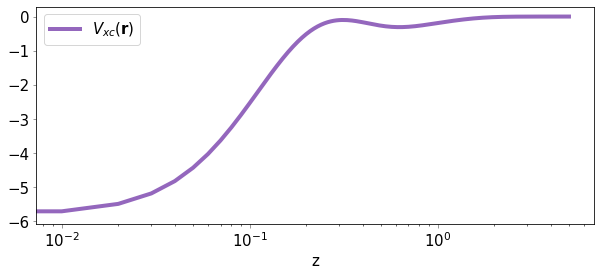

In [44]:
# ZMP

ine.invert(method='zmp', guide_components='fermi_amaldi', lambda_list=np.linspace(10, 1000, 20), opt_max_iter=100, opt_tol=1e-7)

results = ine.eng.grid.esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne = results[1]

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, vxc_ne, lw=4, label="$V_{xc}(\mathbf{r})$", color='tab:purple')
ax.legend(fontsize=15)
ax.set_xlabel('z', fontsize=15)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15, color='grey')
fig.show()


Computing Fermi Amaldi
Optimization Successful within 3 iterations! |grad|=1.35e-04


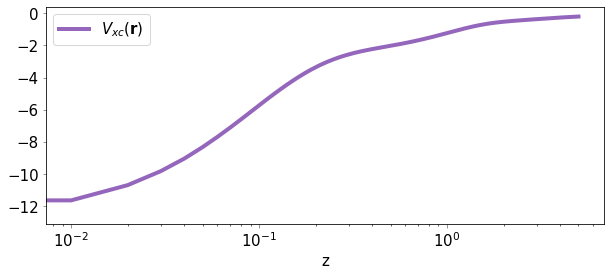

In [45]:
# Wu-Yang

# Perform Wu Yang Inversion with "Fermi-Amaldi" potential as guide. 
ine.invert("WuYang", guide_components="fermi_amaldi")

# Extract quantities on the grid. 
ext, ha ,esp = ine.eng.grid.esp(grid=grid)
vrest = ine.eng.grid.ao(ine.v_pbs, grid=grid, basis=ine.eng.pbs)
fa = (1-1/(ine.nalpha + ine.nbeta)) * ha
vxc = (fa + vrest) - ha

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, vxc, lw=4, label="$V_{xc}(\mathbf{r})$", color='tab:purple')
ax.legend(fontsize=15)
ax.set_xlabel('z', fontsize=15)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15, color='grey')
fig.show()

Computing Fermi Amaldi
4-AO-Overlap tensor will take about 0.000560 GB.
Optimization Successful within 9 iterations! |grad|=3.34e-06.


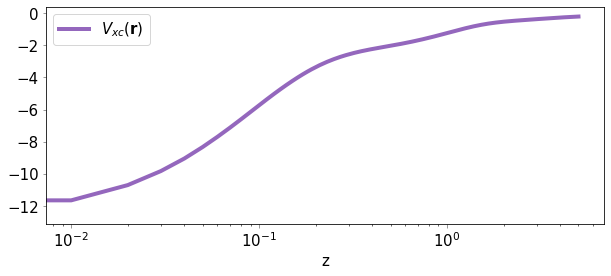

In [46]:
# PEDECO 

ine.invert("PDECO", opt_max_iter=200, guide_components="fermi_amaldi", gtol=1e-6)

ext, ha ,esp = ine.eng.grid.esp(grid=grid)
vrest = ine.eng.grid.ao(ine.v_pbs, grid=grid, basis=ine.eng.pbs)
fa = (1-1/(wfn.nalpha()+ wfn.nbeta())) * ha
vxc = fa + vrest - ha

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, vxc, lw=4, label="$V_{xc}(\mathbf{r})$", color='tab:purple')
ax.legend(fontsize=15)
ax.set_xlabel('z', fontsize=15)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15, color='grey')
fig.show()